In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

training_set = pd.read_csv('Dataset/fashion-mnist_train.csv')
test_set = pd.read_csv('Dataset/fashion-mnist_test.csv')

print(training_set.shape)
print(test_set.shape)

(60000, 785)
(10000, 785)


In [55]:
def data_prep(df, target):
    # Extract feature columns
    feature_columns = [col for col in df.columns if col != target]
    
    # Determine the type of the target column
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    
    # Convert features to float32
    X = df[feature_columns].values.astype(np.float32)
    
    # Convert target to float32
    y = df[target].values.astype(np.float32)
    
    # Handle target based on type
    if target_type in (np.int64, np.int32):
    # One hot encode for classification
        y = pd.get_dummies(df[target]).values.astype(np.float32)
    else:
    # For regression, just convert to float32
        y = df[target].values.astype(np.float32)
    return X, y

In [56]:
# X is pixels, y is labels

X_train, y_train = data_prep(training_set, 'label')
X_test, y_test = data_prep(test_set, 'label')

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

print(y_test[0])

(60000, 784)
(60000, 10)
(10000, 784)
(10000, 10)
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


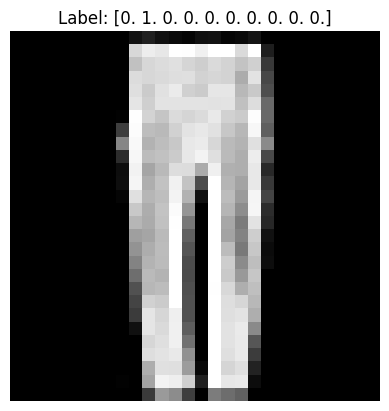

In [57]:
#visualising one image

# choosing an image
image_array = X_train[69]
label = y_train[69]

# reshape 784 to 28x28
image_array = image_array.reshape(28, 28)

# plotting the image
plt.imshow(image_array, cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

In [58]:
# rescaling the pixel values down to values between 0 - 1 for efficiency of neural network

X_train = X_train / 255.0
X_test = X_test / 255.0

In [59]:
class Tanh:
    def __init__(self):
        self.name = 'tanh'

    def forward(self, x):
        return np.tanh(x)
    
    def backward(self, x):
        return 1 - np.tanh(x) ** 2
    
class Softmax:
    def __init__(self):
        self.name = 'softmax'
        self.output = None
    
    def forward(self, x):
        # Subtract max
        shifted_x = x - np.max(x, axis=1, keepdims=True)
        exp_x = np.exp(shifted_x)
        
        # Compute probabilities
        self.output = exp_x / np.sum(exp_x, axis=1, keepdims=True)
        return self.output
    
    def backward(self, grad):
        dx = self.output * (grad - np.sum(grad * self.output, axis=1, keepdims=True))
        return dx
    
class Linear:
    def __init__(self, input_num, output_num):

        # For gradient descent
        self.db = None
        self.dw = None
        
        # Set random seed for reproducibility
        self.rng = np.random.default_rng(42)
        
        # Initialize weights using He initialization
        self.weights = self.rng.normal(
            size=(input_num, output_num)) * np.sqrt(2 / input_num)
        
        # Initialize biases to zeros
        self.bias = np.zeros((1, output_num))
        
        # Store input for backprop
        self.input = None
        
    def forward(self, x):

        self.input = x
        return np.dot(x, self.weights) + self.bias
    
    def backward(self, grad_output):

        # Calculate gradients
        self.dw = np.dot(self.input.T, grad_output)
        self.db = np.sum(grad_output, axis=0, keepdims=True)
        
        # Gradient for next layer
        dx = np.dot(grad_output, self.weights.T)
        
        return dx
    
    def update_params(self, learning_rate):
    
        if self.dw is not None and self.db is not None:
            self.weights -= learning_rate * self.dw
            self.bias -= learning_rate * self.db
        else:
            print("Error: gradients not computed yet")

class CrossEntropyLoss:
    def __init__(self):
        self.predictions = None
        self.targets = None
    
    def forward(self, predictions, targets):
        """
        Forward pass of Cross Entropy Loss
        Args:
            predictions: Softmax outputs (batch_size, num_classes)
            targets: One-hot encoded labels (batch_size, num_classes)
        Returns:
            loss: Scalar loss value
        """
        # Store for backward pass
        self.predictions = predictions
        self.targets = targets
        
        # Add small epsilon to avoid log(0)
        epsilon = 1e-15
        predictions = np.clip(predictions, epsilon, 1 - epsilon)
        
        # Calculate cross entropy loss
        batch_size = predictions.shape[0]
        loss = -np.sum(targets * np.log(predictions)) / batch_size
        
        return loss
    
    def backward(self, predictions, targets):
        """
        Backward pass of Cross Entropy Loss
        Args:
            predictions: Softmax outputs (batch_size, num_classes)
            targets: One-hot encoded labels (batch_size, num_classes)
        Returns:
            gradients with respect to predictions
        """
        # Gradient of cross entropy with respect to predictions
        batch_size = predictions.shape[0]
        grad = (predictions - targets) / batch_size
        
        return grad

In [60]:
class NeuralNetwork:
    def __init__(self, layers, loss_function, learning_rate=0.01):
        """
        Initialize Neural Network
        Args:
            layers: list of layer objects (Linear, Tanh, Softmax)
            loss_function: loss function object
            learning_rate: learning rate for gradient descent
        """
        self.layers = layers
        self.loss_fn = loss_function
        self.learning_rate = learning_rate
    
    def forward(self, x):
        """Forward pass through all layers"""
        activation = x
        for layer in self.layers:
            activation = layer.forward(activation)
        return activation
    
    def backward(self, grad):
        """Backward pass through all layers"""
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
    
    def update_params(self):
        """Update parameters in all Linear layers"""
        for layer in self.layers:
            if hasattr(layer, 'update_params'):
                layer.update_params(self.learning_rate)
    
    def train(self, X_train, y_train, epochs=100, batch_size=32):
        """
        Train the neural network
        Args:
            X_train: training features
            y_train: training labels
            epochs: number of training epochs
            batch_size: size of mini-batches
        """
        n_samples = len(X_train)
        losses = []
        
        for epoch in range(epochs):
            total_loss = 0
            
            # Mini-batch training
            for i in range(0, n_samples, batch_size):
                # Get mini-batch
                batch_X = X_train[i:i + batch_size]
                batch_y = y_train[i:i + batch_size]
                
                # Forward pass
                predictions = self.forward(batch_X)
                
                # Compute loss
                loss = self.loss_fn.forward(predictions, batch_y)
                total_loss += loss
                
                # Backward pass
                grad = self.loss_fn.backward(predictions, batch_y)
                self.backward(grad)
                
                # Update parameters
                self.update_params()
            
            # Print progress
            avg_loss = total_loss / (n_samples / batch_size)
            losses.append(avg_loss)
            
            if epoch % 10 == 0:
                print(f"Epoch {epoch}/{epochs}, Loss: {avg_loss:.4f}")
        
        return losses
    
    def predict(self, X):
        """Make predictions for input X"""
        return self.forward(X)
    
    def evaluate(self, X_test, y_test):
        """
        Evaluate accuracy on test set
        Returns: accuracy score (0-1)
        """
        predictions = self.predict(X_test)
        predicted_classes = np.argmax(predictions, axis=1)
        true_classes = np.argmax(y_test, axis=1)
        accuracy = np.mean(predicted_classes == true_classes)
        return accuracy

In [61]:
def plot_loss(loss_hist):
    plt.plot(loss_hist)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.grid(True)
    plt.show()

Epoch 0/200, Loss: 2.4026
Epoch 10/200, Loss: 2.3027
Epoch 20/200, Loss: 2.3027
Epoch 30/200, Loss: 2.3027
Epoch 40/200, Loss: 2.3027
Epoch 50/200, Loss: 2.3027
Epoch 60/200, Loss: 2.3027
Epoch 70/200, Loss: 2.3027
Epoch 80/200, Loss: 2.3027
Epoch 90/200, Loss: 2.3027
Epoch 100/200, Loss: 2.3027
Epoch 110/200, Loss: 2.3027
Epoch 120/200, Loss: 2.3027
Epoch 130/200, Loss: 2.3027
Epoch 140/200, Loss: 2.3027
Epoch 150/200, Loss: 2.3027
Epoch 160/200, Loss: 2.3027
Epoch 170/200, Loss: 2.3027
Epoch 180/200, Loss: 2.3027
Epoch 190/200, Loss: 2.3027


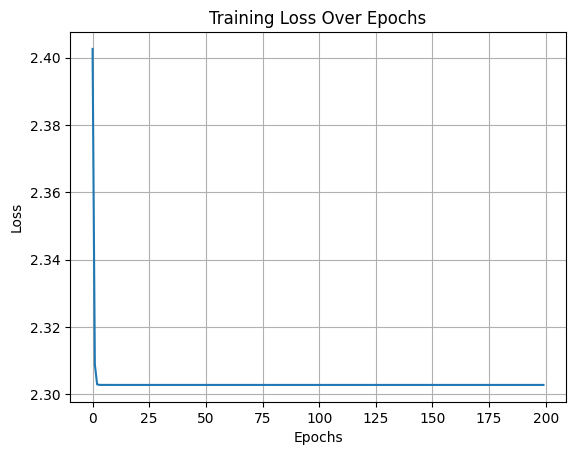

In [64]:
model = NeuralNetwork(
    [
        Linear(X_train.shape[1], 128),  # Increased neurons from 15 to 128
        Tanh(),
        Linear(128, 64),   # Added another layer
        Tanh(),
        Linear(64, 10),
        Softmax()
    ],
    CrossEntropyLoss(), 
    learning_rate=0.001)  # Reduced learning rate for stability

# Increase epochs and reduce batch size
loss_hist = model.train(X_train, y_train, epochs=200, batch_size=16)  # Changed from epochs=100, batch_size=32
plot_loss(loss_hist)